In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, FloatSlider, Checkbox
from scipy.spatial.transform import Rotation

### Konstanter

In [2]:
# KONSTANTER
# Global
simulation_step = 1000      # s
simulation_time = 365 * 24 * 60 * 60 * 10
simulation_total_steps = simulation_time // simulation_step

# Gravitasjon
AU = 1.495978707e11
gamma = 6.67e-11                        # m^3/(kg*s^2)
mass_earth = 5.972e24                   # kg
mass_mars = 6.39e23                     # kg
mass_sun = 1.989e30                     # kg

earth_apoapsis_distance = 1.0167 * AU   # m
earth_apoapsis_velocity = 2.93e4        # m/s

mars_apoapsis_distance = -1.666 * AU    # m
mars_apoapsis_velocity = 2.197e4        # m/s

# Rotasjon
earth_rot_vel = 7.292115e-5             # rad/s
earth_tilt_angle = np.deg2rad(66.5)     # rads

# Klima
sigma = 5.67e-8                         # W/(m^2K^4)
sun_surface_temp = 5772                 # K
earth_albedo = 0.33                     # Skalar
earth_emisitivity = 0.5                 # Skalar

radius_sun = 6.95E8                     # m
radius_earth = 6.371e6                  # m

### Framgangsmåte
(1) Simulerer så jordens bane rundt solen. $\newline$
(2) Deler jorden inn i delareal, dvs. diskrete områder som simuleres hver for seg, med egne parametre. $\newline$
(3) Simulerer jordens rotasjon om egen akse. $\newline$
(4) For hver iterasjon av simuleringen: Regner vi ut strålingspådrivet på hvert av delarealene, og bruker strålingspådrivet for å finne ny temperatur. $\newline$

### Planetsimulering
Gravitasjonskraft:
$$F_G = \frac{\gamma M m}{d^2}$$

Initialiserer posisjonen og banefarten til jorden i sin apoapsis, og bruker fysiske verdier for massen til jorden og solen. Bruker følgende verdier:

$$ v_{apoapsis} = 2.93 \cdot 10^4 \:m/s$$
$$ d_{apoapsis} = 1.0167 * AU $$

Bruker så euler-integrasjon sammen med kraftformelen over for å finne akselerasjonen til jorden:

$$ v_{t + 1} = v_t + \frac{F_G}{m}\Delta t$$
$$ p_{t + 1} = p_t + v_{t + 1} \Delta t$$

(-272027759503.76346,
 229521786837.98727,
 -249692734115.85547,
 249672635901.49164)

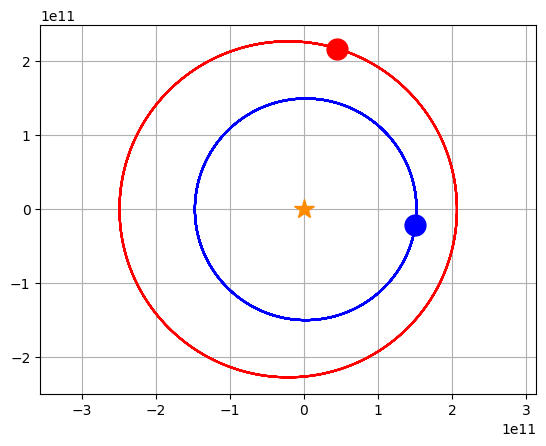

In [3]:
# Variabler
time = 0
earth_position = np.array([earth_apoapsis_distance, 0, 0])
earth_velocity = np.array([0, earth_apoapsis_velocity, 0])
mars_position = np.array([mars_apoapsis_distance, 0, 0])
mars_velocity = np.array([0, mars_apoapsis_velocity, 0])

# Data
pos_data_earth = np.zeros((simulation_total_steps, 3))
pos_data_mars = np.zeros((simulation_total_steps, 3))

# Simulering
for i in range(simulation_total_steps):
    earth_dist = np.linalg.norm(earth_position)
    mars_dist = np.linalg.norm(mars_position)
    if earth_dist:
        earth_velocity -= earth_position * (gamma * mass_sun) / (earth_dist**3) * simulation_step
        earth_position += earth_velocity * simulation_step
        pos_data_earth[i] = earth_position
    if mars_dist:
        mars_velocity -= mars_position * (gamma * mass_sun) / (mars_dist**3) * simulation_step
        mars_position += mars_velocity * simulation_step
        pos_data_mars[i] = mars_position
    time += simulation_step

# Visualisering
plt.plot(pos_data_earth[:,0], pos_data_earth[:,1], 'b')
plt.plot(pos_data_mars[:,0], pos_data_mars[:,1], 'r')
plt.plot(0, 0, '*', color = 'darkorange', markersize = 15)
plt.plot(earth_position[0], earth_position[1], 'ob', markersize = 15)
plt.plot(mars_position[0], mars_position[1], 'or', markersize = 15)
plt.grid(True)
plt.axis('equal')

### Fordeling av jordens overflate
For å kunne fordele jorden inn i delareal må man finne et sett med punkter som kan representere sentrumene til delarealene. Det kan man gjøre ved å dele opp jorden på samme måte som man gjør med kart, nemmelig inn i bredde- og lengdegrader der et hvert punkt blir representert med to vinkler. Vi kaller disse vinklene $\alpha_i$ og $\beta_i$, og vi får følgende formel for å representere vektoren fra sentrum av jorden til punktet:

$$\vec{p_i} = r_j [\cos{(\alpha_i)}\sin{(\beta_i)}, \sin{(\alpha_i)}\sin{(\beta_i)}, \cos{(\beta_i)}]$$

Uttrykket kommer av at vi kombinerer rotasjon rundt z-aksen (vanlig enhetssirkel i xy-planet) med rotasjon rundt y-aksen (rotasjon rundt en sirkel i zx-planet).

Gir vi følgende definisjonsmengder til $\alpha_i$ og $\beta_i$
$$\alpha_i \in [-\pi, \pi] \land \beta_i \in [0, \pi]$$
kan vi direkte overføre det til kart dersom vi konverterer $\beta_i \in [0, \pi] \to [-\pi/2, \pi/2]$.

For å kunne representere jordens rotasjon kan en til vinkel bli lagt til i uttrykket over
$$\vec{p_i} = r_j [\cos{(\alpha_i + \omega t)}\sin{(\beta_i)}, \sin{(\alpha_i + \omega t)}\sin{(\beta_i)}, \cos{(\beta_i)}]$$
hvor $\omega$ er jordens rotasjonshastiget rundt egen akse og $t$ er tiden som har gått i simuleringen.

#### Bedre metode
Bruker lineær algebra. En rotasjonsmatrise og en vektor som representerer rotasjonsaksen til jorden kan bli brukt til å regne ut en fordeling av punkter på jordens overflate gitt ett sett med breddegrader og ett sett med lengdegrader. Merk at breddegradene er i intervallet $[0, \pi]$ og at lengdegradene er i intervallet $[0, 2\pi]$.

In [4]:
# Generering av punkter på planetens overflate
def point_on_sphere(alpha, beta, v, radius = 1):
    # Calculate x,y,z coordinates
    x = np.sin(alpha) * np.cos(beta)
    y = np.sin(alpha) * np.sin(beta)
    z = np.cos(alpha)

    # Create rotation matrix
    v = v / np.linalg.norm(v)
    c = np.cos(np.pi/2)
    s = np.sin(np.pi/2)
    t = 1 - c
    R = np.array([[t*v[0]*v[0]+c, t*v[0]*v[1]-s*v[2], t*v[0]*v[2]+s*v[1]],
                  [t*v[0]*v[1]+s*v[2], t*v[1]*v[1]+c, t*v[1]*v[2]-s*v[0]],
                  [t*v[0]*v[2]-s*v[1], t*v[1]*v[2]+s*v[0], t*v[2]*v[2]+c]])

    # Rotate point
    p = np.array([x,y,z])
    p_rotated = R @ p

    return radius * p_rotated

#### Utregning av overflate-normaler på en sfære

In [5]:
def calculate_surface_normals(points_vec, center = np.array([0, 0, 0])):
    points_vec = np.transpose(points_vec)
    normals = np.array([points_vec[0] - center[0], points_vec[1] - center[1], points_vec[2] - center[2]])
    normals /= np.linalg.norm(normals, axis=0)
    return np.transpose(normals)

def calculate_surface_normals_vec(points_vec, center = np.array([0, 0, 0])):
    normals = np.array([points_vec[0] - center[0], points_vec[1] - center[1], points_vec[2] - center[2]])
    normals /= np.linalg.norm(normals, axis=0)
    return normals

### Finne delareal
For å kunne finne delarealet til et vilkårlig punkt med vinkelen $\delta$ (lik breddegraden tidligere), trenger vi et uttrykk for overflate-arealet til en sfære mellom to vinkler:
$$A = 2\pi r^2(\sin{(\beta)} - \sin{(\alpha)}),$$
hvor $\alpha$ og $\beta$ er to vinkler. Setter vi vinkelen $\alpha = \delta - \Delta v$ og $\beta = \delta + \Delta v$, der $\Delta v$ er den diskrete vinkelforskjellen mellom to vertikale lag med punkter ovenfor. 
http://www.usrsb.in/blog/blog/2011/08/11/the-surface-area-of-a-sphere-between-parallel-planes/

In [6]:
def calculate_area_of_sphere(angle, radius, delta, num_of_horizontal_points):
    alpha = angle - delta
    beta = angle + delta
    return 2 * np.pi * radius * radius * (np.sin(beta) - np.sin(alpha)) / num_of_horizontal_points

print(f"Jordens overflate-areal er: {calculate_area_of_sphere(0, radius_earth, np.pi/2, 1)} m^2")

Jordens overflate-areal er: 510064471909788.25 m^2


### Jordens rotasjon

In [7]:
num_of_vertical_points = 30
num_of_horizontal_points = 30

# Plotte overflate-normal-vektorene
def plot_quiver(vec, ax):
    normals = calculate_surface_normals_vec(vec) # vec er allerede transposert til denne funksjonen for at funksjonen skal kunne vektoriseres
    
    # Plotter sfæren sine normal-vektorer
    ax.quiver(vec[0], vec[1], vec[2], normals[0], normals[1], normals[2], length = 0.25)

@interact(time = FloatSlider(value = 0.0, min = 0.0, max = 86400.0, step = 10), angle = FloatSlider(value=0, min=-90.0, max=90.0, step=0.5), normals = Checkbox(value=False))
def animate_points(time, angle, normals):
    # Jordens rotasjons-akse
    earth_rot_vec = np.array([0, np.cos(np.pi / 2 - np.deg2rad(angle)), np.sin(np.pi / 2 - np.deg2rad(angle))])

    # Utregning av punkter på jordens overflate
    points = []
    for beta in np.linspace(0, 2 * np.pi - 2 * np.pi / num_of_horizontal_points, num_of_horizontal_points): 
        for alpha in np.linspace(0, -np.pi, num_of_vertical_points):
            points.append(point_on_sphere(alpha, beta + earth_rot_vel * time, earth_rot_vec))

    color_map = [i for i in range(len(points))]
    points = np.array([points])
    points_t = np.transpose(points)

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

    ax.set_xlim3d(-1, 1)
    ax.set_ylim3d(-1, 1)
    ax.set_zlim3d(-1, 1)

    if normals: plot_quiver(points_t, ax)
    ax.scatter(points_t[0], points_t[1], points_t[2], c=color_map, cmap='inferno')

    plt.show()

interactive(children=(FloatSlider(value=0.0, description='time', max=86400.0, step=10.0), FloatSlider(value=0.…

### Utregning av innstrålingsintensitet
Sollyset som treffer jorden treffer ikke hele jorden i like mengder. Ved å ta skalarproduktet mellom normalvektoren til et punkt på overflaten til jorden og vektoren som representerer det innkommende strålingspådrivet kan man få frem dette.
$$\text{Effektiv innstråling} = \vec{A} \cdot \vec{I_{sol}} = dA \cdot I_{sol} \cdot \sin{\alpha}$$
der $dA$ er et vilkårlig delareal av jorden, $I_{sol}$ er den innstrålte effekten per kvadratmeter til området og $\alpha$ er vinkelen mellom areal-vektoren, som peker normalt ut av delarealet, og sol-vektoren som peker fra sentrum av delarealet til solen.  

In [8]:
def calculate_intensity(alpha, beta, pos, radius, rot_vec):
    points = point_on_sphere(alpha, beta, rot_vec, radius)
    points_pos = points + pos
    normals = calculate_surface_normals(points_pos, pos)
    points_pos_norm = points_pos / np.linalg.norm(points_pos)
    intensity = normals @ points_pos_norm
    return intensity

### Instrålingstetthet - Solarkonstanten

Energien i sollyset som når jorden er fordelt på et enormt kuleskall med radius like stort som avstanden mellom solen og jorden:

$$r_{sj}= 1AU = 1.496\cdot 10^{11}m$$ 

Intensitet som man finner ved å dele solens totale effekt på arealet av dette enorme kuleskallet kalles for solens innstrålingstetthet. Dette tallet kalles også solkonstanten og kan beregnes som:
$$I_{sol} = \frac{P_{sol}}{4\pi r_{sj}^2}$$

In [9]:
def calculate_sun_radiated_power(pos):
    P_sol = sigma * sun_surface_temp**4 * 4 * np.pi * radius_sun ** 2
    I_sol = P_sol / (4 * np.pi * np.linalg.norm(pos)**2)
    return I_sol

In [15]:
# Visualisering
@interact(tilt_angle = FloatSlider(value=23.5, min=0.0, max=90), time = FloatSlider(value = 0.0, min = 0.0, max = 86400.0, step = 1000))
def visualize_intensity(tilt_angle, time):
    I_sol = calculate_sun_radiated_power(np.array([earth_apoapsis_distance, 0, 0]))
    earth_rot_vec = np.array([0, np.cos(np.pi / 2 - np.deg2rad(tilt_angle)), np.sin(np.pi / 2 - np.deg2rad(tilt_angle))])
    print(f"Solens innstrålte effekt per kvadratmeter: {format(I_sol, '.5')}W/m^2")

    tot_sun = 0.0
    values = []
    alpha = np.linspace(0, np.pi, 30)
    beta = np.linspace(0, 2*np.pi, 30)
    for b in beta:
        col = []
        for a in alpha:
            # TODO: Fix issue with intensity
            intensity = max(calculate_intensity(a, b + earth_rot_vel * time, np.array([earth_apoapsis_distance, 0, 0]), radius_earth, earth_rot_vec), 0)
            area = calculate_area_of_sphere(a - np.pi/2, radius_earth, np.pi/(2 * num_of_vertical_points), num_of_horizontal_points)
            col.append(area * I_sol * intensity)
            tot_sun += area * I_sol * intensity
        values.append(col[::-1])
    print(f"Den totale effekten av solens strålingspådriv: {format(tot_sun, '.3')}W")
    plt.xlabel("Index into beta-array")
    plt.ylabel("Index into alpha-array")
    plt.imshow(np.transpose(np.array(values)))
    plt.colorbar()
    plt.show()


interactive(children=(FloatSlider(value=23.5, description='tilt_angle', max=90.0), FloatSlider(value=0.0, desc…